## Markov Chain Monte Carlo Simulation of Precipitation Data
### David Islip

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
import scipy.stats as stats
import numpy as np
import math
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.tsa.ar_model as ar_model
from  InvarianceTestEllipsoid import InvarianceTestEllipsoid
from autocorrelation import autocorrelation
from collections import Counter
import pickle
%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
P = pd.read_csv("Cleaned Precipitation.csv")

P.rename(columns={P.columns[0]: 'Date'}, inplace=True)
P.index = pd.to_datetime(P["Date"])
P.drop(P.index[P.index.dayofyear == 366],axis=0, inplace = True)
P.drop("Date", axis = 1, inplace = True)
P = P['1987-01-01':'2017-01-01 ']
#P.plot(subplots = True, fontsize = 6,layout = (4,4));

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


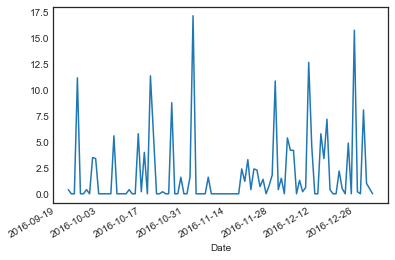

In [3]:
y = P['Buttonville A']
y.ix[-100:].plot()

In [4]:
state = y > 0.1
def estimateMarkov(state):
    p = np.zeros((2,2))
    for (a,b), c in Counter(zip(state, state[1:])).items():
        p[a-1,b-1] = c
    
    return p.flatten()

In [5]:
T = {}
for dy in range(1,365):
    T[dy] = estimateMarkov(state[((state.index.dayofyear == dy) | (state.index.dayofyear == dy+1))])
T[365] = estimateMarkov(state[((state.index.dayofyear == 365) | (state.index.dayofyear == 1))])

In [6]:
Trans_Probs = pd.DataFrame(T).transpose()
Trans_Probs.index.names = ['dayofyear']
Trans_Probs['p11'] = Trans_Probs[0]/(Trans_Probs[0]+Trans_Probs[1])
Trans_Probs['p10'] = Trans_Probs[1]/(Trans_Probs[0]+Trans_Probs[1])
Trans_Probs['p01'] = Trans_Probs[2]/(Trans_Probs[2]+Trans_Probs[3])
Trans_Probs['p00'] = Trans_Probs[3]/(Trans_Probs[2]+Trans_Probs[3])

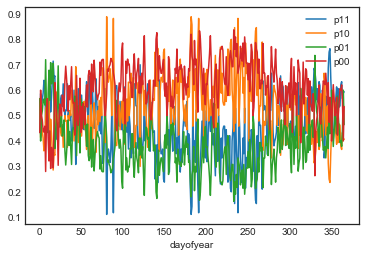

In [7]:
Trans_Probs[['p11','p10','p01','p00']].plot();

### Factor modelling the transition probabilities 

In [8]:
Pr = Trans_Probs.copy()
Pr.drop([0,1,2,3],inplace = True, axis = 1)
#generating the factor space for the mean
a = np.ones(len(Pr))
N = 5 #number of sine and cosine functions to include
n = np.linspace(1,N,N)
t = np.linspace(1,len(Pr),len(Pr))
Sines = np.sin(2*np.pi*(np.outer(t,n))/(4*365))
Cosines = np.cos(2*np.pi*(np.outer(t,n))/(4*365))
X = np.expand_dims(a, axis=1)
X = np.concatenate((X,Sines,Cosines),axis=1)
cols = ['Constant']
for i in range(N):
    cols.append('sin(2pi*'+str(i+1)+'t/1460)')
for i in range(N):
    cols.append('cos(2pi*'+str(i+1)+'t/1460)')
X = pd.DataFrame(X,columns = cols,index = Pr.index)

In [12]:
Pr

,p11,p10,p01,p00
dayofyear,,,,
1,0.433333,0.566667,0.566667,0.433333
2,0.586207,0.413793,0.400000,0.600000
3,0.548387,0.451613,0.500000,0.500000
4,0.562500,0.437500,0.518519,0.481481
5,0.588235,0.411765,0.560000,0.440000
6,0.638889,0.361111,0.565217,0.434783
7,0.628571,0.371429,0.541667,0.458333
8,0.470588,0.529412,0.720000,0.280000
9,0.464286,0.535714,0.516129,0.483871


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Results for model: Buttonville A
                            OLS Regression Results                            
Dep. Variable:                    p11   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 05 Dec 2017   Prob (F-statistic):                nan
Time:                        00:12:58   Log-Likelihood:                 254.58
No. Observations:                 365   AIC:                            -507.2
Df Residuals:                     364   BIC:                            -503.3
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       0.46

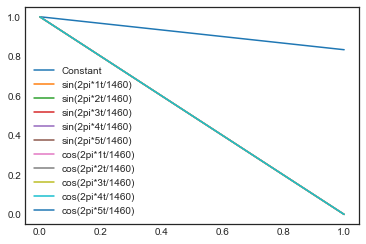

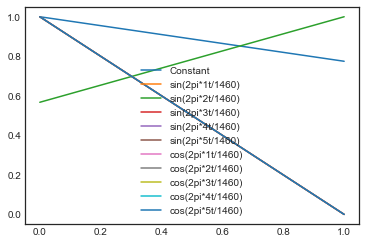

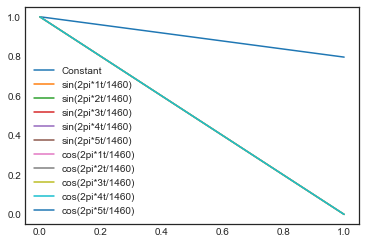

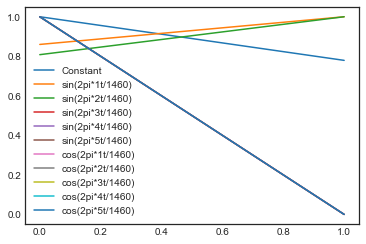

In [13]:
model_results = []
factors = []
for k in range(Pr.shape[1]): #for each transition probability 
    z = Pr[Pr.columns[k]]
    L = []
    model = sm.OLS(z, X)
    for i in range(2):
        results = model.fit_regularized(method = 'elastic_net',alpha=i/10, L1_wt=0.5)
        L.append(results.params)
    L = pd.DataFrame(L)
    L = L/L.max(axis=0)
    cols = L.columns[L.ix[len(L)-1] > 0.01]
    factors.append(cols)
    Xs = X[cols]
    model = sm.OLS(z,Xs)
    results = model.fit()
    print("Results for model: "+str(P.columns[k]))
    L.plot()
    print(results.summary())
    model_results.append(results)

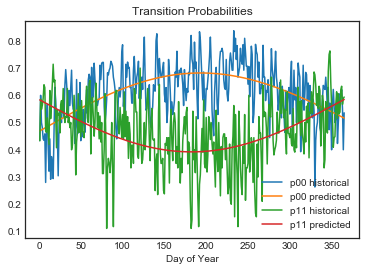

In [14]:
p00 = np.transpose(model_results[3].predict())
p10 = np.transpose(model_results[1].predict())
transition_probs = pd.DataFrame(np.array([Pr['p00'], p00, 1- Pr['p10'], 1 - p10]).transpose(),
                                index = range(1,365+1), 
                                columns = ['p00 historical', 'p00 predicted', 'p11 historical', 'p11 predicted'])
transition_probs.index.names = ['Day of Year']
transition_probs.plot(title = "Transition Probabilities")

### Plot some monte carlo simulations (dry/wet)

In [15]:
#tau is the risk horizon
tau_ = 365*2
tau = dt.timedelta(days = tau_)

start = P.index[-1]
end = start+tau

t = np.arange(P.index[-1],P.index[-1] + dt.timedelta(tau_),dt.timedelta(days=1)).astype(dt.datetime)

M = 10000

invariants  = np.random.uniform(0, 1, (tau_,M))
X_precip = np.zeros((tau_,M))
zero = np.zeros(M)
one = np.ones(M)
for i in range(tau_-1):
    dayofyear = t[i].timetuple().tm_yday
    #state zero
    X_precip[i+1,X_precip[i,] < 1] = invariants[i+1,X_precip[i,] < 1] > p00[dayofyear-1]
    #state 1
    X_precip[i+1,X_precip[i,] == 1] = invariants[i+1,X_precip[i,] == 1] > p10[dayofyear-1]
#plt.plot(X_precip[:,1]);
X_precip.mean()

0.41759986301369861

In [16]:
wet = y[y>0.1]
kdes = {}
for months in range(1,12+1):
    kdes[months] = stats.gaussian_kde(wet[wet.index.month == months],bw_method = 0.01)
#plt.hist((kdes[1].resample(M)).transpose(),bins = 40);

Text(0.5,0,'Z')

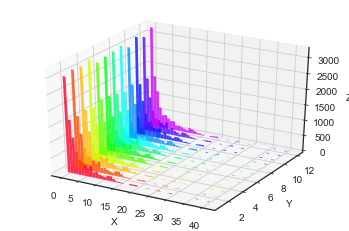

In [17]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
nbins = 50
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = 12
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
for c,months in zip(colors,range(1,12+1)):
    ys = kdes[1].resample(M)
    hist, bins = np.histogram(ys, bins=nbins)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=months, zdir='y',color = c, alpha=0.8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


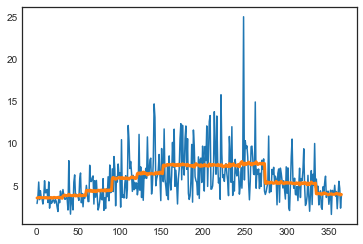

In [18]:
#Lets simulate Yt for the monte carlo simulation... each day simulate 1000 paths 
Y_t = np.zeros((tau_,M))

for i in range(tau_):
    Y_t[i,:] = kdes[t[i].timetuple().tm_mon].resample(M)
y_wet = y.drop(y.index[y<0.1])
y_wet = y_wet.groupby(y_wet.index.dayofyear).mean()
plt.plot(range(1,365+1),y_wet,label = "Conditional mean temperature on a daily basis" );
plt.plot(range(1,365+1),Y_t[0:365,].mean(axis=1), label = "Conditional mean memperature on a monthly basis", lw = 3);

In [19]:
X_precip.shape
P_path = np.multiply(Y_t, X_precip)
#plt.plot(P_path[:,:10]);

### Pickle the simulations

In [20]:
P_out = pd.DataFrame(P_path)
P_out.index = t
P_out.to_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Pout.pkl")

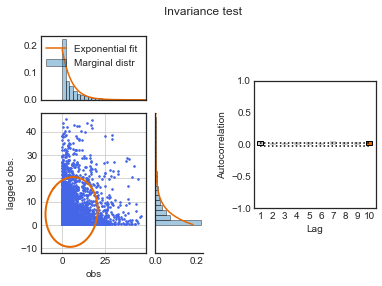

In [21]:
wet = np.expand_dims(y[y>0.1],axis = 0)
lag_ = 10 # number of lags (for auto correlation test)
acf = autocorrelation(wet, lag_)

lag = 10 # lag to be printed
ell_scale = 2  # ellipsoid radius coefficient
fit = 2  # normal fitting
InvarianceTestEllipsoid(wet, acf[0,1:], lag, fit, ell_scale);